### Research notebook to generate features from COVID text

- extract keywords 
- preprocess
- lemmatize
- do TF-IDF
- reduce dimensions with UMAP
- find clusters with HDBSCAN

#### Get RAKE for keyword extraction

In [ ]:
!pip install rake-nltk

In [137]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from rake_nltk import Rake
%matplotlib inline

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import umap

In [5]:
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3',context='talk', fscale=1.4, spines=False, gridlines='--')

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
#for clustering, see https://hdbscan.readthedocs.io/en/latest/index.html for details
import hdbscan

#### Get spacy for lemmatization

In [9]:
import spacy

Download spacy large model (takes a few minutes)  
Note that the kernel will need to be restarted before the model becomes loadable

In [ ]:
!python -m spacy download en_core_web_lg

In [10]:
spacy_nlp = spacy.load("en_core_web_lg",disable=['parser', 'ner'])

In [11]:
spacy_nlp.max_length = 1700000

In [12]:
dataset = pd.read_csv("../assemble/covid_full_processed.csv")

In [13]:
dataset.dtypes

Microsoft Academic Paper ID    float64
WHO #Covidence                  object
authors                         object
doi                             object
doi_url                         object
has_full_text                   object
journal                         object
license                         object
pmcid                           object
publish_time                    object
pubmed_id                      float64
sha                             object
source_x                        object
source                          object
title                           object
abstract                        object
text_body                       object
dtype: object

In [18]:
def preprocess_text(text):

  '''
  Remove all punctuation apart from "-" and convert text to lower case
  Also remove anything that is not letters or numbers
  '''
  
  text = text.translate(str.maketrans('', '', string.punctuation.replace("-","")))
  text = re.sub("[^a-zA-Z-]+", " ", text)
  text = text.lower()

  return text

rakeobj = Rake(min_length=2,max_length=10) # Uses stopwords for english from NLTK, and all puntuation characters.


def get_key_phrases(text,rakeobj):
    
    '''
    Apply basic RAKE to extract key phrases
    '''
    
    rakeobj.extract_keywords_from_text(text)
    
    key_phrases = rakeobj.get_ranked_phrases()
    
    return key_phrases


def lemmatize(text):
    
    '''
    Use spacy to do lemmatization on article texts
    '''
    
    truncated_text = text[:spacy_nlp.max_length]
    
    doc = spacy_nlp(truncated_text)
    
    return " ".join([token.lemma_ for token in doc])
    

In [14]:
dataset.isna().sum()

Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
authors                          946
doi                             3143
doi_url                            0
has_full_text                  12080
journal                        11709
license                        11808
pmcid                           2163
publish_time                   11252
pubmed_id                      12770
sha                            12080
source_x                           0
source                         16281
title                          17230
abstract                       25076
text_body                      16281
dtype: int64

In [138]:
if os.path.exists("articles_preprocessed_lemmatized.csv"):
    
    body_only = pd.read_csv("articles_preprocessed_lemmatized.csv")

else:
    
    #This preprocessing takes ~ 30 mins, mainly due to lemmatization
    
    body_only = dataset.dropna(subset=['text_body'])
    
    body_only['title'] = body_only['title'].fillna("")
    body_only['abstract'] = body_only['abstract'].fillna("")
    body_only['all_text'] = body_only['title'] + ' ' + body_only['abstract'] + body_only["text_body"]
    body_only['processed_text'] = body_only['all_text'].apply(preprocess_text)
    body_only['key_phrases'] = body_only['all_text'].apply(get_key_phrases, args=(rakeobj,))
    body_only['lemmatized_preprocessed_text'] = body_only['processed_text'].apply(lemmatize)
    body_only['log_total_words'] = body_only['all_text'].apply(lambda x: np.log(len(x.split(" "))))
    body_only['log_total_key_phrases'] = body_only['key_phrases'].apply(lambda x: 0 if len(x) == 0 else np.log(len(x)))
    body_only['total_chars'] = body_only['all_text'].apply(lambda x: len(x))
    body_only.to_csv("articles_preprocessed_lemmatized.csv",index=False)

In [16]:
body_only.isna().sum()

Microsoft Academic Paper ID    13080
WHO #Covidence                 13070
authors                          452
doi                              301
doi_url                            0
has_full_text                      0
journal                          803
license                            0
pmcid                            952
publish_time                     360
pubmed_id                       1024
sha                                0
source_x                           0
source                             0
title                            949
abstract                        8795
text_body                          0
dtype: int64

In [140]:
max(body_only["total_chars"])

1679269

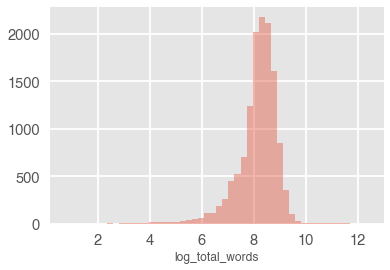

In [141]:
sns.distplot(body_only["log_total_words"],kde=False);

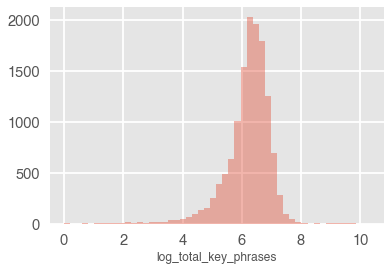

In [142]:
sns.distplot(body_only["log_total_key_phrases"],kde=False);

### Use TfidfVectorizer to create large feature dataset

Note that we may want to lemmatize first!

Takes a long time! Theres no point using a large ngram range if max_features is small, but max_features shouldn't be huge because that will make dimensionaltiy reduction very time consuming

In [22]:
from nltk.corpus import stopwords 
stop_words = list(set(stopwords.words('english'))) + ["fig","figure", "et", "al"]

In [143]:
%%time
vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=[1,2],min_df=10,max_df=0.8,max_features=5000)
X = vectorizer.fit_transform(body_only['lemmatized_preprocessed_text'])

CPU times: user 1min 56s, sys: 4.53 s, total: 2min 1s
Wall time: 2min 3s


In [144]:
len(vectorizer.get_feature_names())

5000

In [145]:
vectorizer.get_feature_names()[:10]

['aa',
 'ab',
 'abcam',
 'abdominal',
 'ability',
 'able',
 'abnormal',
 'abnormality',
 'abolish',
 'absence']

In [146]:
colors = LabelEncoder().fit_transform(y=body_only["source"])

In [147]:
len(pd.unique(colors))

4

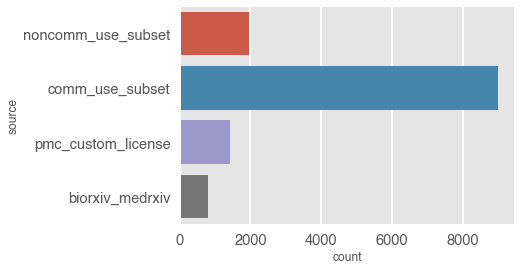

In [148]:
sns.countplot(y=body_only["source"]);

In [149]:
phrase_features = vectorizer.get_feature_names()

In [150]:
def plot_dataset_decomp(embedding,title,colors=None):
    
    '''Plot a dataset that has been reduced to 2D'''
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    if isinstance(colors,np.ndarray):
        plt.scatter(
            embedding[:, 0], embedding[:, 1], c=colors, cmap=plt.cm.get_cmap('rainbow', len(pd.unique(colors))), s=0.8
        )
        plt.colorbar()
    else:
        plt.scatter(
            embedding[:, 0], embedding[:, 1], c='red', s=1.2
        )
        
    plt.title(title, fontsize=18)

In [151]:
X.shape

(13219, 5000)

In [152]:
X_dense = np.array(X.todense())

In [153]:
X_dense.shape

(13219, 5000)

### Attempt PCA

There is no reason to think that the dataset should be linearly seperable. This separates one of the source types farily well, but otherwise doesn't really help 

In [154]:
%%time
pca = PCA(n_components=2).fit(X_dense)
pca_embedding = pca.transform(X_dense)

CPU times: user 8.38 s, sys: 871 ms, total: 9.25 s
Wall time: 4.75 s


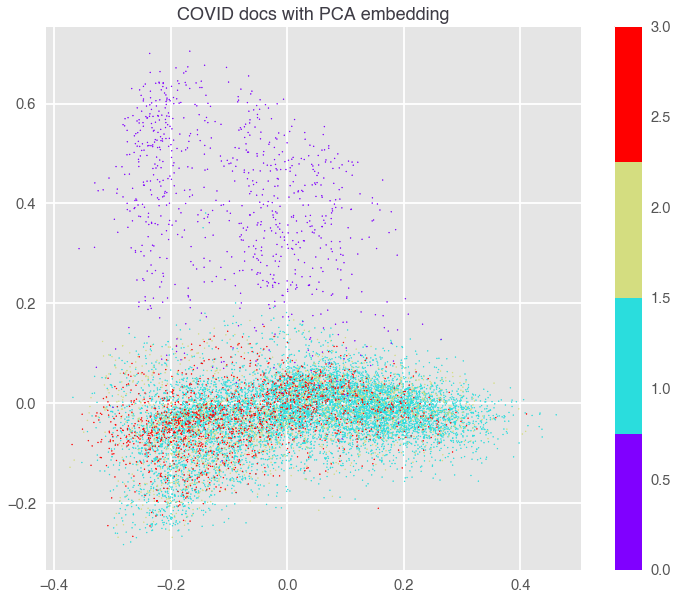

In [155]:
plot_dataset_decomp(pca_embedding,"COVID docs with PCA embedding",colors)

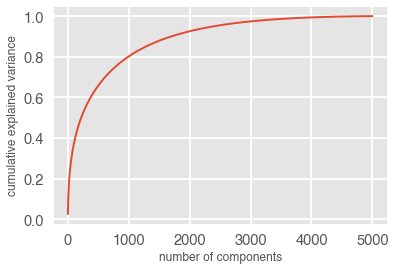

In [156]:
pca = PCA().fit(X_dense)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This shows that we need about 1000 components to explain 80% of the variance of the dataset, so clearly PCA is not a good tool for visualizing this data 

### Investigate the effect of adding a total log words column to the dataset

In [167]:
total_words_col = body_only["log_total_words"].values.reshape(-1,1)

In [168]:
X_dense_wordcol = np.hstack([X_dense,total_words_col])

In [169]:
X_dense_wordcol = StandardScaler().fit_transform(X_dense_wordcol)

In [170]:
%%time
pca = PCA(n_components=2).fit(X_dense_wordcol)
pca_embedding = pca.transform(X_dense_wordcol)

CPU times: user 8.74 s, sys: 1.24 s, total: 9.99 s
Wall time: 12.7 s


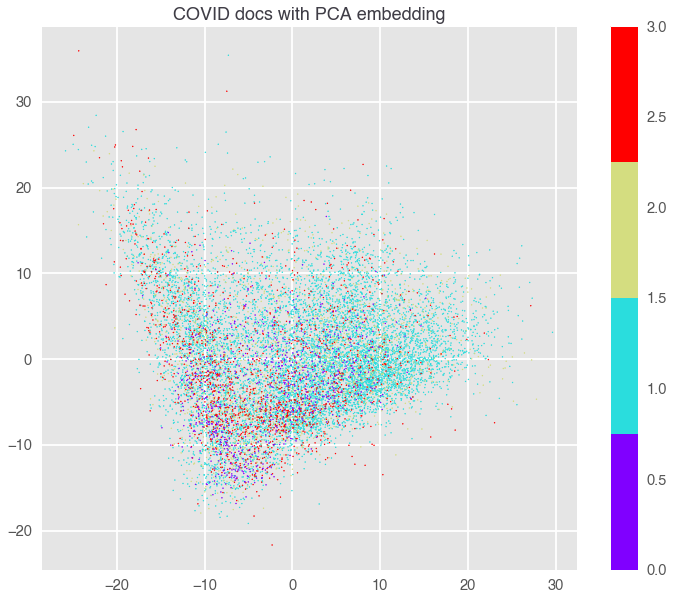

In [171]:
plot_dataset_decomp(pca_embedding,"COVID docs with PCA embedding",colors)

### Attempt UMAP

UMAP works farily well at seperating the data into some distinct clusters, which a density based clustering algorithm would be able to pick up on. 

We need to check of the articles in the clusters are actually similar though

In [157]:
%%time 
umap_fit = umap.UMAP(
    n_neighbors=400,
    min_dist=0,
    n_components=2,
    random_state=42,
    metric="euclidean"
).fit(X_dense)

CPU times: user 2min 38s, sys: 5.74 s, total: 2min 43s
Wall time: 2min 50s


In [158]:
umap_embedding = umap_fit.transform(X_dense)

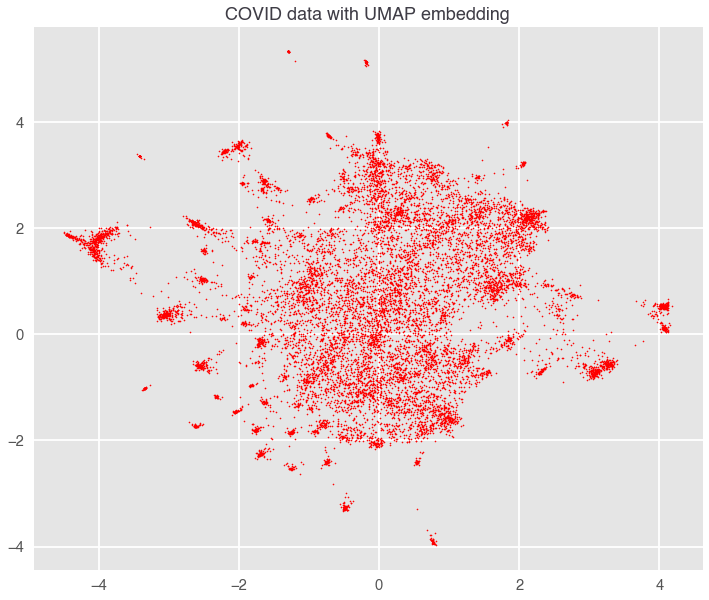

In [159]:
plot_dataset_decomp(umap_embedding,"COVID data with UMAP embedding")

In [160]:
labels = hdbscan.HDBSCAN(
    min_samples=None,
    min_cluster_size=50,
).fit_predict(umap_embedding)

In [161]:
len(pd.unique(labels))

23

In [162]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [163]:
clustered = (labels >= 0)

#This is the proportation of data that we clustered
100.0*np.sum(clustered) / X_dense.shape[0]

90.36992208185188

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


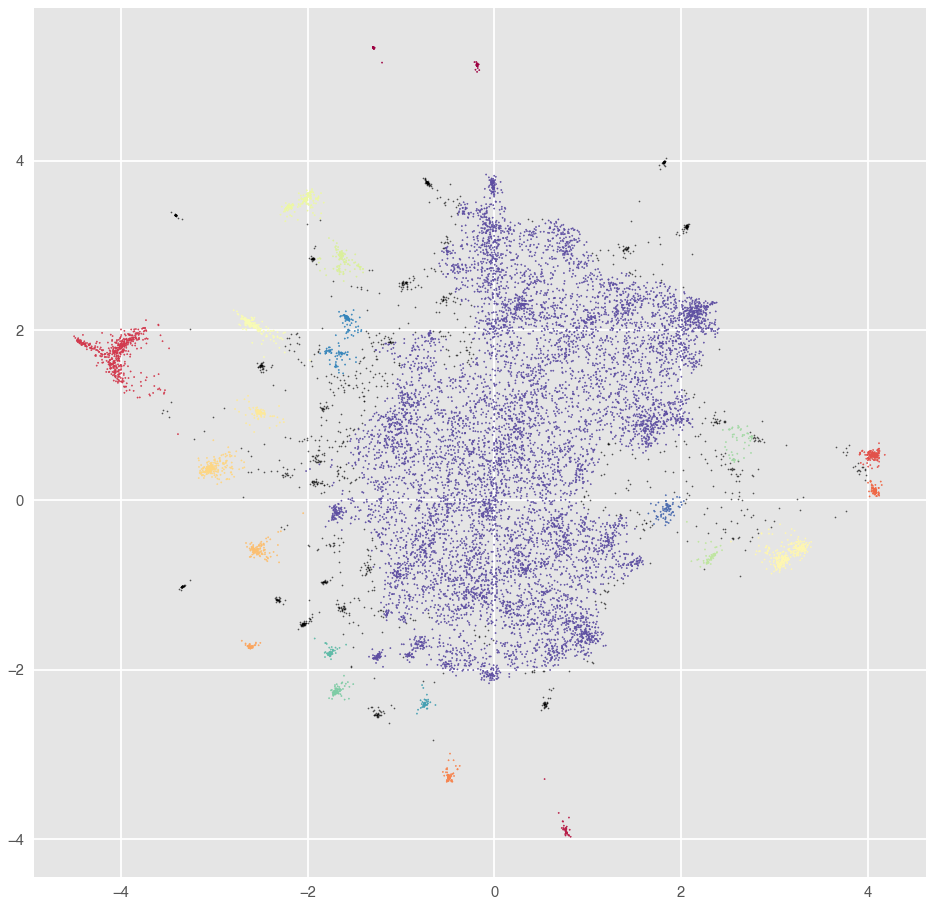

In [164]:
fig = plt.figure(figsize=(16,16))
plt.style.use("ggplot")
ax = fig.add_subplot(111)
clustered = (labels >= 0)
ax.scatter(umap_embedding[~clustered, 0],
            umap_embedding[~clustered, 1],
            c=(0, 0, 0),
            s=1.5,
            alpha=0.5)
ax.scatter(umap_embedding[clustered, 0],
            umap_embedding[clustered, 1],
            c=labels[clustered],
            s=1.5,
            cmap='Spectral');

In [166]:
len(labels)

13219

In [ ]:
body_only["label "]